In [47]:
import csv
from env import DATABASE_URI
from sqlalchemy import create_engine, select, and_
from sqlalchemy.orm import Session, scoped_session, sessionmaker
from data_models import Data

sensors = ['E4', 'E3']
run_id = 13

engine = create_engine(DATABASE_URI)
Session = scoped_session(sessionmaker(bind=engine))
session = Session()

def sensor_csv(session, run_id, sensor):
    query = select(Data).where(Data.run_id == run_id)
    data = session.execute(query).scalars().all()
    with open(f"/home/hayden/repos/module_pcb_thermal_mockup/module_pcb_thermal_mockup_v3.5/software/run_{run_id}_{sensor}.csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Time", sensor])
        for row in data:
            if row.sensor == sensor:
                writer.writerow([row.timestamp.isoformat(), row.celcius])

for sensor in sensors:
    sensor_csv(session, run_id, sensor)

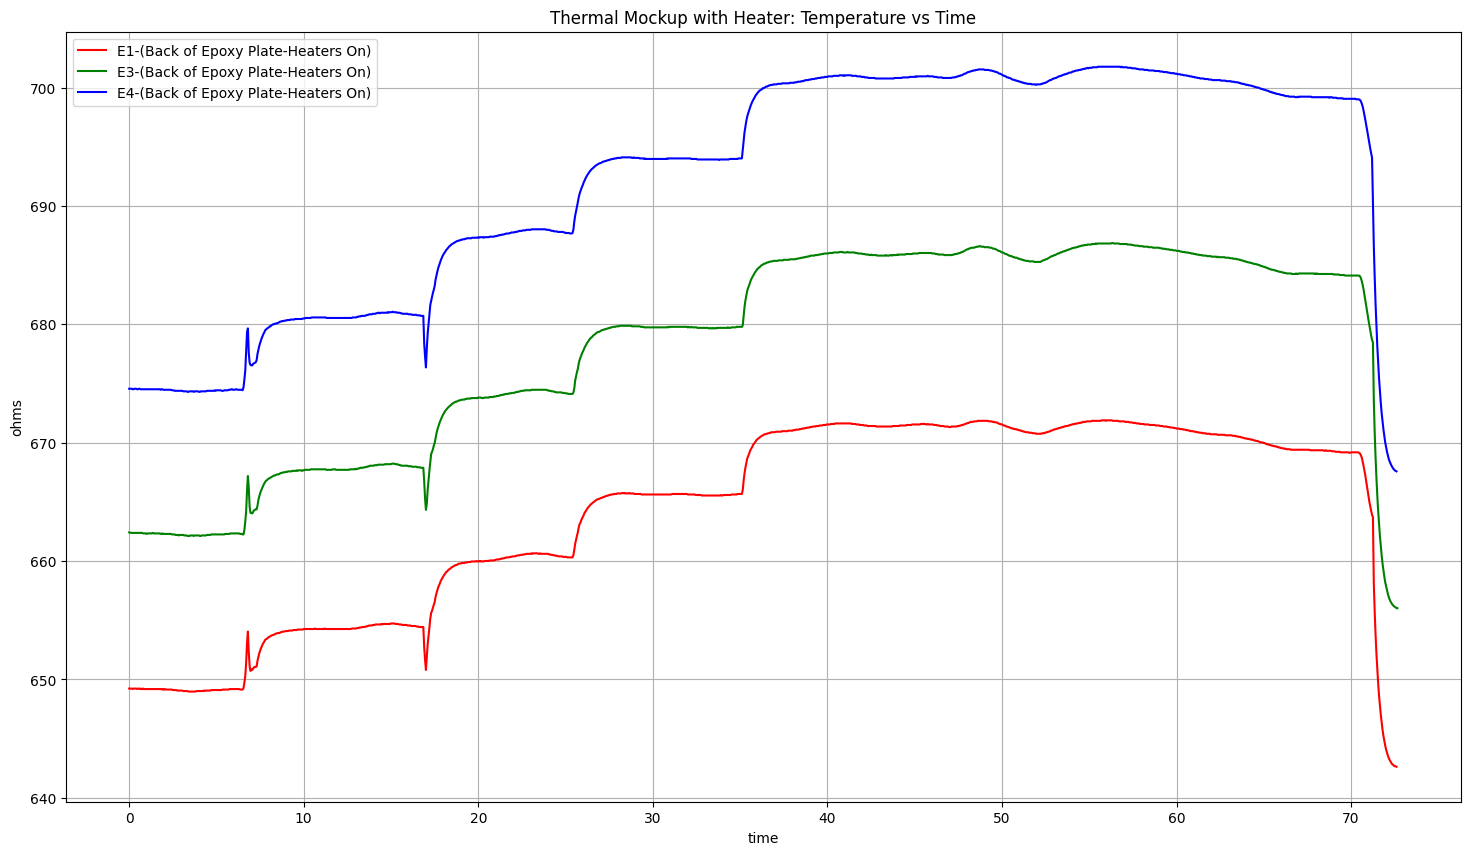

In [9]:
import matplotlib.pyplot as plt
from env import DATABASE_URI
from sqlalchemy import create_engine, select, and_
from sqlalchemy.orm import Session, scoped_session, sessionmaker
from data_models import Data
from matplotlib import colormaps

engine = create_engine(DATABASE_URI)
Session = scoped_session(sessionmaker(bind=engine))
session = Session()

def get_sensor_data(run_id: int, sensor: str, cut_in=0) -> tuple[list, list]:
    query = select(Data).where(and_(Data.run_id == run_id, Data.sensor == sensor))
    data = session.execute(query).scalars().all()

    t0 = data[cut_in].timestamp
    elapsed_time = lambda t: (t - t0).total_seconds() / 60 

    times = [elapsed_time(row.timestamp) for row in data]
    temps = [row.ohms for row in data]
    return times[cut_in:], temps[cut_in:]

def plot_run_data(ax, run_id: int, sensors: list, label: str, color: str, cut_in: int = 0):
    #cmap = plt.get_cmap(color, len(sensors))
    colors = ['red', 'green', 'blue']
    for i, sensor in enumerate(sensors):
        s_times, s_temps = get_sensor_data(run_id, sensor, cut_in=cut_in)
        ax.plot(s_times, s_temps, label=f"{sensor}-{label}", color=colors[i])#cmap(i / len(sensors)))

sensors = ['E1', 'E3', 'E4']

fig, ax = plt.subplots(figsize=(18,10))

# plot_run_data(ax, 3, sensors, "(Back of Epoxy Plate-Heaters ON)", 'Greens')
plot_run_data(ax, 3, sensors, "(Back of Epoxy Plate-Heaters On)", 'Blues')
# plot_run_data(ax, 7, sensors, "(Front of Epoxy Plate-Heaters OFF)", 'Purples')
# plot_run_data(ax, 8, sensors, "(Front of Epoxy Plate-Heaters ON)", 'Oranges')
#plot_run_data(ax, 12, sensors, "(Back of Solder Plate-NO HEATER)", 'Reds', cut_in=600)

ax.set(
    xlabel='time',
    ylabel='ohms',
    title = 'Thermal Mockup with Heater: Temperature vs Time'
)

ax.legend()
ax.grid()


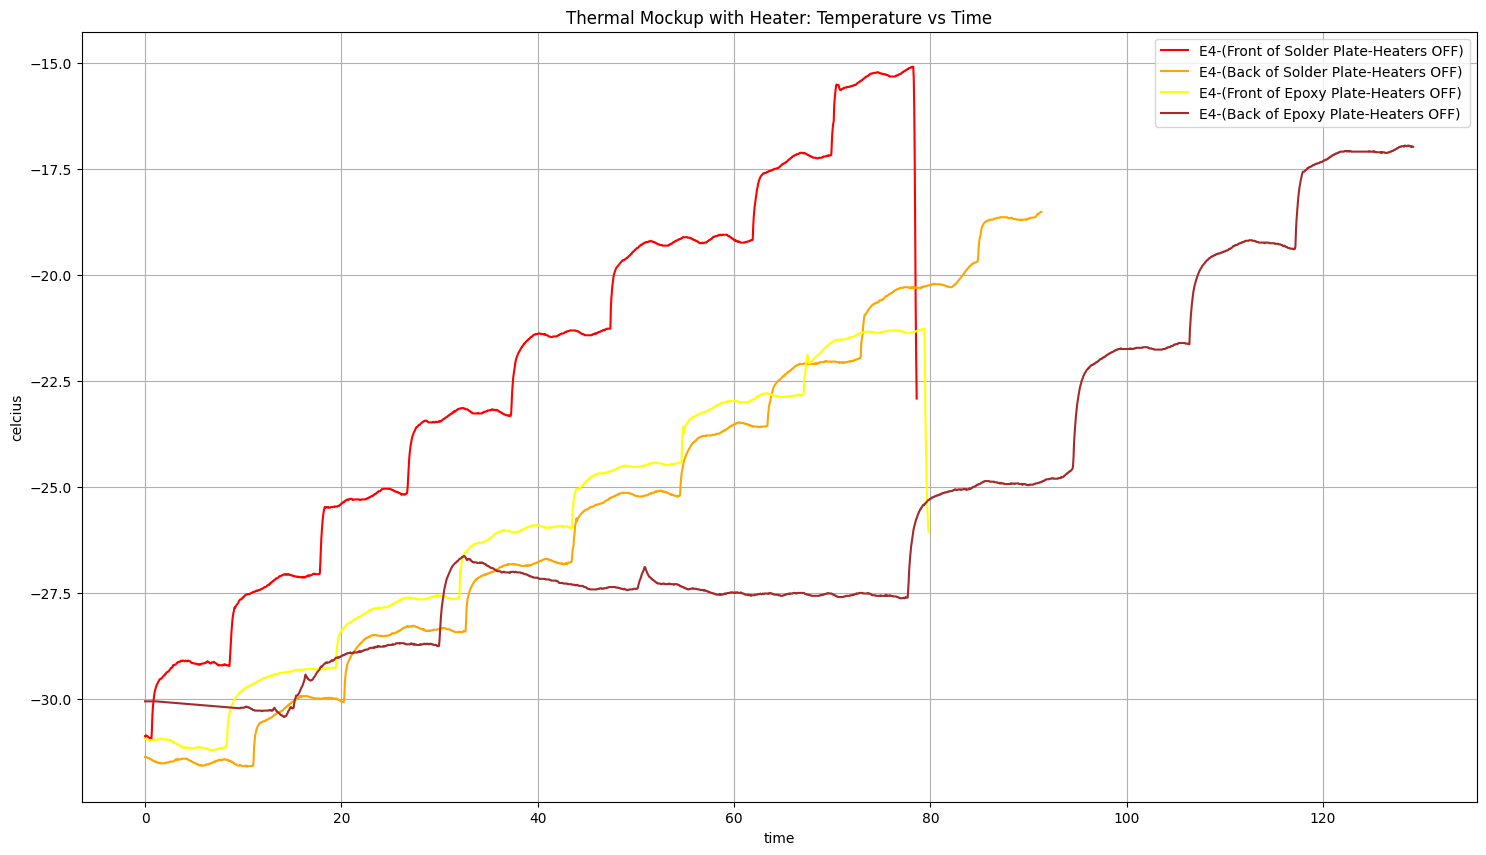

In [45]:

def plot_run_data(ax, run_id: int, sensors: list, label: str, colors: list, cut_in: int = 0):
    for i, sensor in enumerate(sensors):
        s_times, s_temps = get_sensor_data(run_id, sensor, cut_in=cut_in)
        ax.plot(s_times, s_temps, label=f"{sensor}-{label}", color=colors[i])


fig, ax = plt.subplots(figsize=(18,10))

sensors=['E4']
plot_run_data(ax, 13, sensors, "(Front of Solder Plate-Heaters OFF)", ['red', 'blue'], cut_in=40)
plot_run_data(ax, 12, sensors, "(Back of Solder Plate-Heaters OFF)", ['orange', 'purple'], cut_in=600)

plot_run_data(ax, 7, sensors, "(Front of Epoxy Plate-Heaters OFF)", ['yellow', 'green'])
plot_run_data(ax, 4, sensors, "(Back of Epoxy Plate-Heaters OFF)", ['brown', 'deeppink'])


ax.set(
    xlabel='time',
    ylabel='celcius',
    title = 'Thermal Mockup with Heater: Temperature vs Time'
)

ax.legend()
ax.grid()